In [1]:
## Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

In [2]:
comments_path = "/Users/katiecartiglia/Desktop/merged_output.parquet"
comments = pd.read_parquet(f"{comments_path}", engine="pyarrow")

In [3]:
comments.head(5)

,subreddit,author,author_flair_text,body,parent_id,link_id,id,created_utc,score,day,month,year,supported_team
0,CollegeBasketball,Little_Jerry,:lubbockchristian: :texastech: Lubbock Christi...,What’s wrong with him? He was pulled after a m...,t1_htkb6xh,t3_s90b2x,htkcp1z,2022-01-21 05:57:48,2,21,1,2022,lubbockchristian
1,CollegeBasketball,pachauaia,:ucla: UCLA Bruins,Have not felt like a top 10 team since we play...,t3_s90b2x,t3_s90b2x,htkcpcs,2022-01-21 05:57:53,10,21,1,2022,ucla
2,CollegeBasketball,Celery-Man,:ucla: :connecticut: UCLA Bruins • Connecticut...,Finally getting Riley involved in the offense.,t3_s90b2x,t3_s90b2x,htkcpnn,2022-01-21 05:57:58,1,21,1,2022,ucla
3,CollegeBasketball,PadKrapowKhaiDao,:indiana: Indiana Hoosiers,That last sentence is fucking gold. I’m gonna ...,t1_htk73yo,t3_s8zq93,htkcpr1,2022-01-21 05:57:59,3,21,1,2022,indiana
4,CollegeBasketball,cfbonly,:michiganstate2: Michigan State Spartans,I'm not even mad at that. respect.,t1_htk437k,t3_s917cg,htkcqam,2022-01-21 05:58:07,86,21,1,2022,michiganstate2


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(comments['body'])

In [5]:
kmeans = KMeans(n_clusters=3, random_state=42)

In [6]:
pipeline = make_pipeline(tfidf_vectorizer, kmeans)

In [7]:
pipeline.fit(comments['body'])

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [8]:
comments['cluster'] = pipeline.predict(comments['body'])

In [9]:
print(comments.groupby('cluster')['body'].count())

cluster
0    1138027
1     137625
2     106864
Name: body, dtype: int64


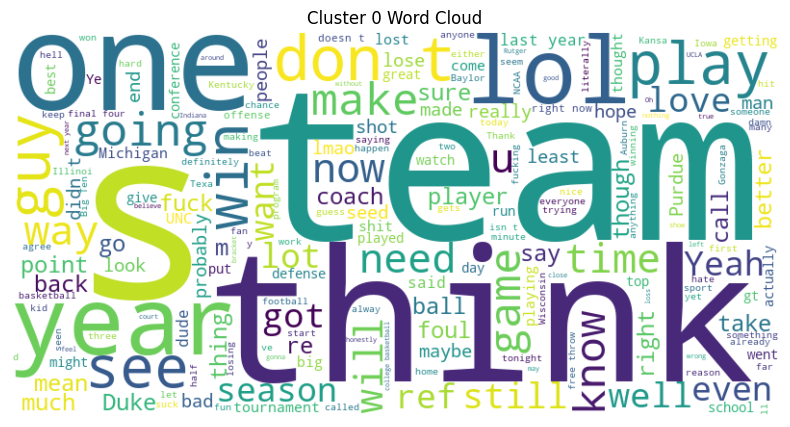

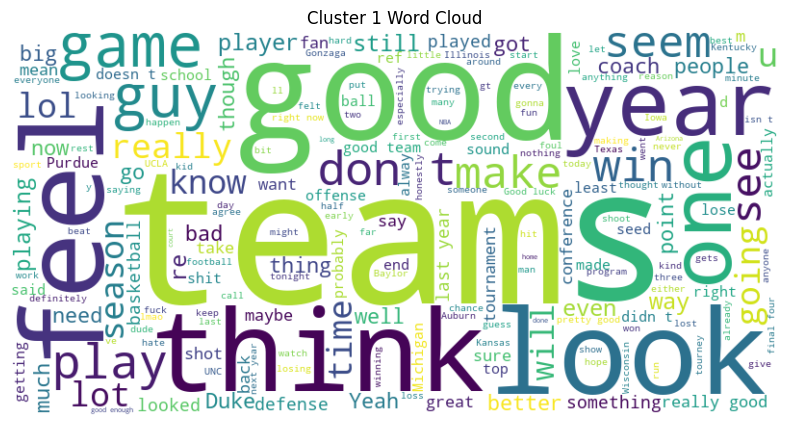

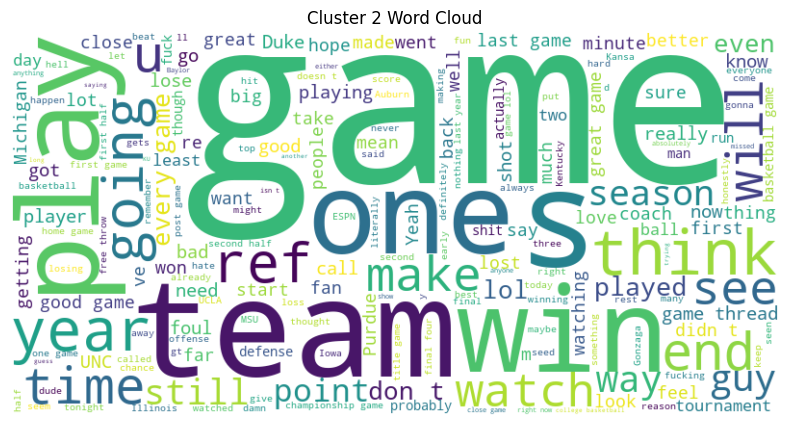

In [11]:
from wordcloud import WordCloud

for cluster_num in range(3):
    cluster_words = ' '.join(comments[comments['cluster'] == cluster_num]['body'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster_num} Word Cloud')
    plt.axis('off')
    plt.show()


In [12]:
terms = tfidf_vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for cluster_num in range(3):
    top_keywords = [terms[ind] for ind in order_centroids[cluster_num, :10]]
    print(f'Cluster {cluster_num} Top Keywords: {", ".join(top_keywords)}')


Cluster 0 Top Keywords: just, lol, team, don, year, think, fuck, time, big, foul
Cluster 1 Top Keywords: like, good, just, team, looks, don, really, year, feel, think
Cluster 2 Top Keywords: game, just, like, win, good, team, refs, play, ve, watch


hi


## Now, using NLP analysis also


### First Model

In [4]:
comments.head(5)

,subreddit,author,author_flair_text,body,parent_id,link_id,id,created_utc,score,day,month,year,supported_team
0,CollegeBasketball,Little_Jerry,:lubbockchristian: :texastech: Lubbock Christi...,What’s wrong with him? He was pulled after a m...,t1_htkb6xh,t3_s90b2x,htkcp1z,2022-01-21 05:57:48,2,21,1,2022,lubbockchristian
1,CollegeBasketball,pachauaia,:ucla: UCLA Bruins,Have not felt like a top 10 team since we play...,t3_s90b2x,t3_s90b2x,htkcpcs,2022-01-21 05:57:53,10,21,1,2022,ucla
2,CollegeBasketball,Celery-Man,:ucla: :connecticut: UCLA Bruins • Connecticut...,Finally getting Riley involved in the offense.,t3_s90b2x,t3_s90b2x,htkcpnn,2022-01-21 05:57:58,1,21,1,2022,ucla
3,CollegeBasketball,PadKrapowKhaiDao,:indiana: Indiana Hoosiers,That last sentence is fucking gold. I’m gonna ...,t1_htk73yo,t3_s8zq93,htkcpr1,2022-01-21 05:57:59,3,21,1,2022,indiana
4,CollegeBasketball,cfbonly,:michiganstate2: Michigan State Spartans,I'm not even mad at that. respect.,t1_htk437k,t3_s917cg,htkcqam,2022-01-21 05:58:07,86,21,1,2022,michiganstate2


In [4]:
comments.dropna(subset=['supported_team'], inplace=True)

# adapted from https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(comments['body'])
y = comments['supported_team']

In [5]:
# adapted from https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
model = MultinomialNB()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [7]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.16397354132023745


/Users/katiecartiglia/opt/anaconda3/envs/ANLY501/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/katiecartiglia/opt/anaconda3/envs/ANLY501/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

                               0.00      0.00      0.00       659
                 Jay_Doc       0.00      0.00      0.00         3
                     aac       0.00      0.00      0.00         8
        abilenechristian       0.00      0.00      0.00        21
                     acc       0.00      0.00      0.00       164
                airforce       0.00      0.00      0.00        11
                   akron       0.00      0.00      0.00        32
                 alabama       0.40      0.02      0.03      2209
         alaskaanchorage       0.00      0.00      0.00         3
         alaskafairbanks       0.00      0.00      0.00         2
                  albany       0.00      0.00      0.00         7
                american       0.00      0.00      0.00         7
             angelostate       0.00      0.00      0.00         1
        appalachianstate       0.00      0.00      0.00       126
         

/Users/katiecartiglia/opt/anaconda3/envs/ANLY501/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model alone shows us a few things. First, it has a very low accuracy. That tells us that it is very difficult to predict which team each commenter supports just by using what they comment on. That leads us to our second conclusion: that posters write about things beyond their own teams. This gives us insight into the college basketball poster atmosphere writ large, as people are interested in teams outside of just their own bubble. Now, we'll see if we can increase the accuracy of prediction by using a different model.

## Second Model

In [7]:
from sklearn.svm import LinearSVC

model = LinearSVC(random_state=15)
model.fit(X_train, y_train)

# 5. Model Evaluation
# 5.1 Evaluate on Test Set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.18630571296663248


/Users/katiecartiglia/opt/anaconda3/envs/ANLY501/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/katiecartiglia/opt/anaconda3/envs/ANLY501/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/katiecartiglia/opt/anaconda3/envs/ANLY501/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

                          precision    recall  f1-score   support

                               0.09      0.02      0.03       652
                 Jay_Doc       0.00      0.00      0.00         2
                     aac       0.00      0.00      0.00         9
        abilenechristian       0.00      0.00      0.00        24
                     acc       0.14      0.04      0.06       158
                airforce       0.04      0.03      0.04        32
                   akron       0.00      0.00      0.00        26
                 alabama       0.27      0.05      0.09      2292
         alaskaanchorage       0.00      0.00      0.00         7
         alaskafairbanks       0.00      0.00      0.00         2
                  albany       0.00      0.00      0.00         7
               allegheny       0.00      0.00      0.00         0
                american       0.00      0.00      0.00        15
             angelostate       0.00      0.00      0.00         1
        a

/Users/katiecartiglia/opt/anaconda3/envs/ANLY501/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/katiecartiglia/opt/anaconda3/envs/ANLY501/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Interesting! This model had a very slightly higher accuracy, although not by much. This confirms our analysis from running the first model: that predictions based on what people comment about are very hard, and one theory behind that is that college basketball has a robust community of commenters who each care about games beyond who their own team is. This is also relevant because at the end of the season, 64 teams are in a tournament to win the championship, so each fan needs to be very engaged to be ready for the end of the season. This is one theory about why these accuracy scores shown here are so low; there are certainly others.